In [1]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_cluster import knn_graph
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import tensorflow as tf
import pandas as pd

from gcn_toolkit import gcn_model

2024-02-12 10:46:22.838793: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 10:46:22.838858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 10:46:23.176181: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 10:46:23.840987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 10:46:33.994480: W tensorflow/compiler/tf2

In [2]:
# Check GPU availability

print("Num GPUs available: ", len(tf.config.list_physical_devices('GPU')), 
      "\nCuda available: ", torch.cuda.is_available(),
     "\nCuda device count: ", torch.cuda.device_count(),
     "\ncurrent device: ", torch.cuda.current_device(),
     "\ndevice info: ", torch.cuda.device(0), 
      "\ndevice name: ", torch.cuda.get_device_name(0))

Num GPUs available:  2 
Cuda available:  True 
Cuda device count:  2 
current device:  0 
device info:  <torch.cuda.device object at 0x2af6cd6c36d0> 
device name:  Tesla P100-SXM2-16GB


In [8]:
# Data Loaders

graph_data = torch.load('/beegfs/desy/group/unihh2/cms-llp/run3/v10/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV/graphs/graphs9k8nn_' + str(1) + '.pt')

batch_size = 256

train_graphs = graph_data[:6000]
val_graphs = graph_data[6000:8000]
test_graphs = graph_data[8000:]

train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False)

train_loader_test = DataLoader(train_graphs, batch_size=1, shuffle=True)

print(len(train_graphs), len(val_graphs), len(test_loader))

6000 2000 1586


In [9]:
for batch in train_loader:
    print(batch)
    break

DataBatch(x=[92309, 9], edge_index=[2, 738472], y=[256], u=[7168], batch=[92309], ptr=[257])


In [10]:
tool = gcn_model()

In [11]:
tool.make_model(hidden_channels = 9)

GCN(
  (conv1): GCNConv(9, 9)
  (conv2): GCNConv(9, 9)
  (conv3): GCNConv(9, 9)
  (lin1): Linear(in_features=37, out_features=27, bias=True)
  (lin2): Linear(in_features=27, out_features=18, bias=True)
  (lin3): Linear(in_features=18, out_features=9, bias=True)
  (lin4): Linear(in_features=9, out_features=1, bias=True)
)


In [12]:
# Training Loop

train_losses = []
val_losses = []

for epoch in range(1, 100):
    tool.train(train_loader)
    train_loss = tool.test(train_loader)
    val_loss = tool.test(val_loader)
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}')

Epoch: 001, Train Loss: 34163.2656, Test Loss: 35084.5195
Epoch: 002, Train Loss: 34152.9844, Test Loss: 35138.7578
Epoch: 003, Train Loss: 34267.7070, Test Loss: 35025.2656
Epoch: 004, Train Loss: 34402.2266, Test Loss: 34988.2773
Epoch: 005, Train Loss: 34453.3633, Test Loss: 35035.1992
Epoch: 006, Train Loss: 34314.4102, Test Loss: 35077.2031
Epoch: 007, Train Loss: 34014.7148, Test Loss: 35081.8281
Epoch: 008, Train Loss: 34190.1133, Test Loss: 35011.8164
Epoch: 009, Train Loss: 34143.1523, Test Loss: 35135.2305
Epoch: 010, Train Loss: 34143.8555, Test Loss: 35068.4375
Epoch: 011, Train Loss: 34241.4648, Test Loss: 35074.8008
Epoch: 012, Train Loss: 34128.5352, Test Loss: 35085.6445
Epoch: 013, Train Loss: 34349.5469, Test Loss: 35159.4258
Epoch: 014, Train Loss: 34313.3789, Test Loss: 35008.0508
Epoch: 015, Train Loss: 34511.4648, Test Loss: 35075.0352
Epoch: 016, Train Loss: 34110.4727, Test Loss: 35229.7109
Epoch: 017, Train Loss: 34212.5430, Test Loss: 35033.7578
Epoch: 018, Tr

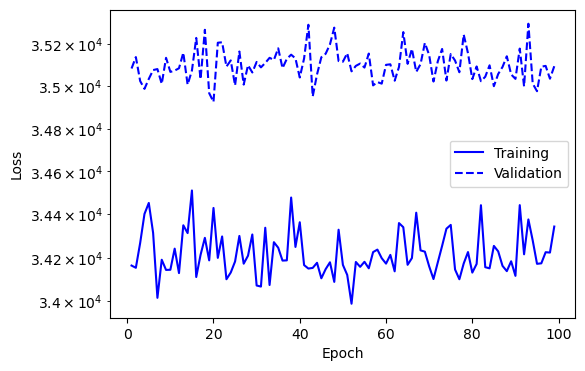

In [13]:
tool.plot_loss(train_losses, val_losses)

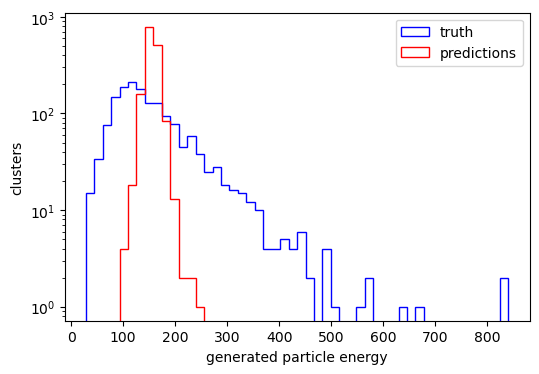

In [9]:
tool.predict(test_loader)

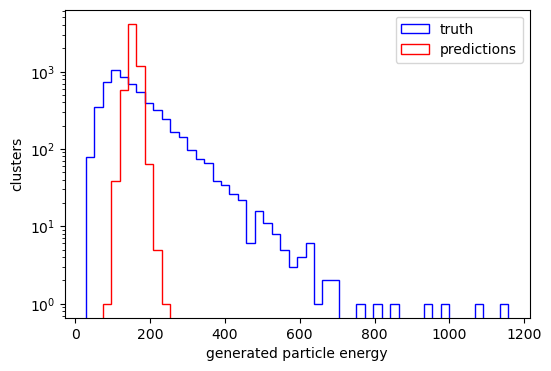

In [10]:
tool.predict(train_loader_test)

 ## old stuff, now in Class


In [5]:
# Model

input_channels = 7

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(7, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final sequential layer
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [35]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    mloss = 0
    runs = 0
    for data in loader:  # Iterate in batches over the training/test dataset
        out = model(data.x, data.edge_index, data.batch)
        mloss += criterion(out, data.y)
        runs += 1
    mloss /= runs
    return mloss

def predict_plot(predictions, labels, title = None, axlabels = ('clusters', 'generated particle energy')):
    fig, ax = plt.subplots(figsize = (6, 4))
    
    histdata, bins, dummy = ax.hist(labels, bins = 50, histtype="step", color = 'b', label = 'truth')
    ax.hist(predictions, bins = bins, histtype="step", color = 'r', label = 'predictions')
    ax.set_yscale('log')
    ax.set_ylabel(axlabels[0])
    ax.set_xlabel(axlabels[1])
    ax.legend()
    if title:
        ax.set_title(title)

def predict(loader):
    model.eval()
    labels = []
    pred = []
    for data in loader:
        pred.append(model(data.x, data.edge_index, data.batch).item())
        labels.append(data.y.item()) 
        #rint(model(data.x, data.edge_index, data.batch).item())
        #rint(data.y.item())
    predict_plot(pred, labels)
        
print(model)

GCN(
  (conv1): GCNConv(7, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=1, bias=True)
)


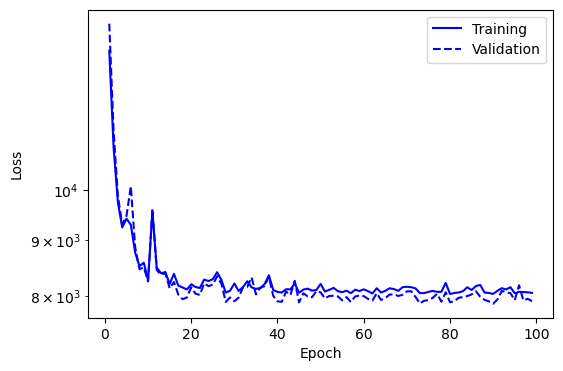

In [17]:
plot_loss(train_losses, val_losses)

In [16]:
def plot_loss(train, val):
    fig, ax = plt.subplots(figsize = (6, 4))
    epoch = np.arange(1, len(train) + 1)
    plt.plot(epoch, train, label = 'Training', color = 'blue')
    plt.plot(epoch, val, label = 'Validation',linestyle = '--', color = 'blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [18]:
from source import gcn_tools

In [20]:
tool = gcn_tools.gcn_tools()

In [23]:
tool.test()

works <source.gcn_tools.gcn_tools object at 0x2b8c4cc908b0>


0